In [33]:
from sklearn.metrics import rand_score, silhouette_score, confusion_matrix, davies_bouldin_score, calinski_harabasz_score
import pandas as pd
from sklearn.cluster import MiniBatchKMeans
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
import gower
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from sklearn.model_selection import train_test_split
from sklearn.cluster import AgglomerativeClustering
#from sklearn_extra.cluster import KMedoids
from scipy.spatial.distance import squareform
from scipy.optimize import linear_sum_assignment
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.metrics import pairwise_distances
from sklearn.manifold import MDS
from scipy.spatial.distance import euclidean, pdist, squareform
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
import seaborn as sns
from sklearn.cluster import MiniBatchKMeans

In [11]:
file_path = 'data_preprocessed.csv'
data = pd.read_csv(file_path)
data = data.dropna()


# Identify numerical and categorical columns
numerical_columns = ['age','fnlwgt', 'hours-per-week', 'capital-gain', 'capital-loss']  # Replace with your actual numerical columns
categorical_columns = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']  # Replace with your actual categorical columns
sorted_columns = ['age','fnlwgt', 'hours-per-week', 'capital-gain', 'capital-loss', 'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']

scaler = StandardScaler()
data[numerical_columns] = scaler.fit_transform(data[numerical_columns])

y = pd.get_dummies(data['income'], drop_first=True)
y = y.values.reshape(-1)
X = data.drop('income', axis=1)

for col in categorical_columns:
   X[col] = X[col].astype('category')

X = X[sorted_columns]

X, _, y, _ = train_test_split(X, y, train_size=1000, stratify=y, random_state=42)

In [13]:
gower = gower.gower_matrix(X, cat_features = [False]*len(numerical_columns)+[True]*len(categorical_columns))

In [15]:
mds = MDS(n_components=4, dissimilarity="precomputed", random_state=42)
X_mds = mds.fit_transform(gower)

c:\Users\kaami\anaconda3\lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


In [19]:
X_train_mds, X_test_mds, y_train, y_test = train_test_split(X_mds, y, test_size=0.2, stratify=y, random_state=42)

In [28]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_mds, y_train)

# Make predictions
y_train_pred = rf.predict(X_train_mds)
y_test_pred = rf.predict(X_test_mds)

# Calculate accuracy and F1 scores
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
train_f1 = f1_score(y_train, y_train_pred)
test_f1 = f1_score(y_test, y_test_pred)

c:\Users\kaami\anaconda3\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


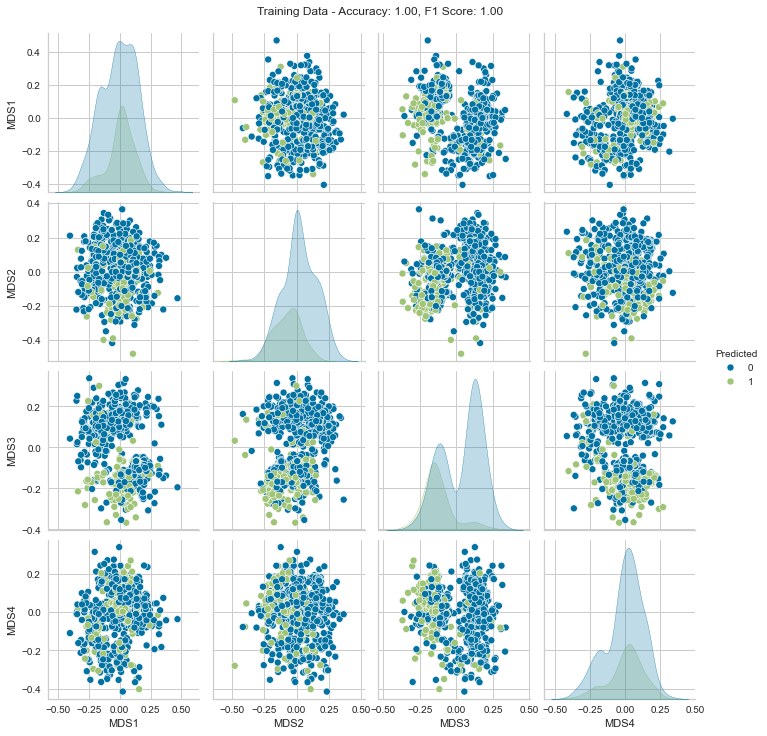

c:\Users\kaami\anaconda3\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


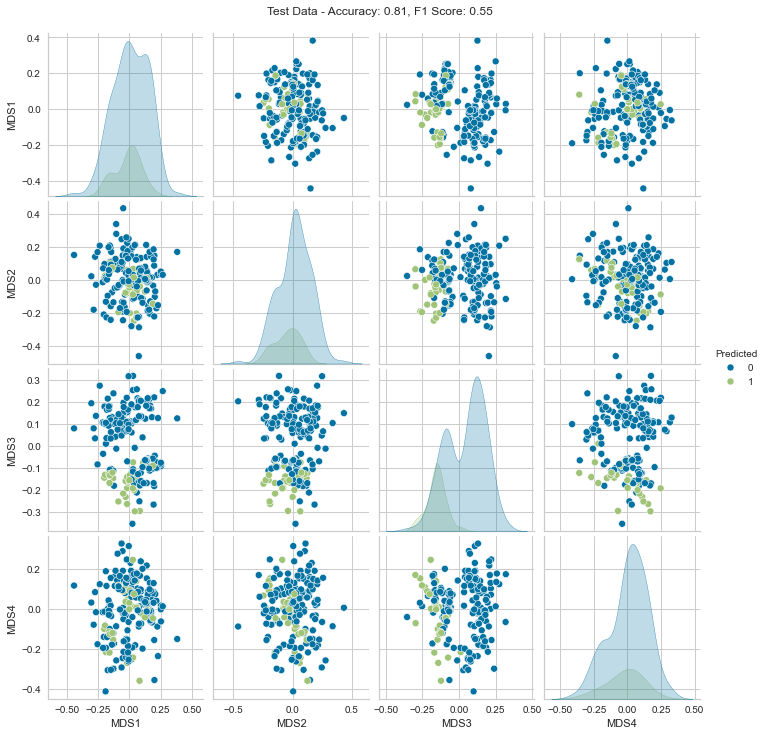

In [31]:
# Prepare dataframes for pairplot
train_df = pd.DataFrame(X_train_mds, columns=['MDS1', 'MDS2', 'MDS3', 'MDS4'])
train_df['Label'] = y_train
train_df['Predicted'] = y_train_pred

test_df = pd.DataFrame(X_test_mds, columns=['MDS1', 'MDS2', 'MDS3', 'MDS4'])
test_df['Label'] = y_test
test_df['Predicted'] = y_test_pred

# Plot pairplot for training data
sns.pairplot(train_df, hue='Predicted', vars=['MDS1', 'MDS2', 'MDS3', 'MDS4'])
plt.suptitle(f'Training Data - Accuracy: {train_accuracy:.2f}, F1 Score: {train_f1:.2f}', y=1.02)
plt.savefig('Dimension_reduction/RF_train.jpg', bbox_inches='tight')
plt.show()

# Plot pairplot for test data
sns.pairplot(test_df, hue='Predicted', vars=['MDS1', 'MDS2', 'MDS3', 'MDS4'])
plt.suptitle(f'Test Data - Accuracy: {test_accuracy:.2f}, F1 Score: {test_f1:.2f}', y=1.02)
plt.savefig('Dimension_reduction/RF_test.jpg', bbox_inches='tight')
plt.show()

c:\Users\kaami\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)
c:\Users\kaami\anaconda3\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


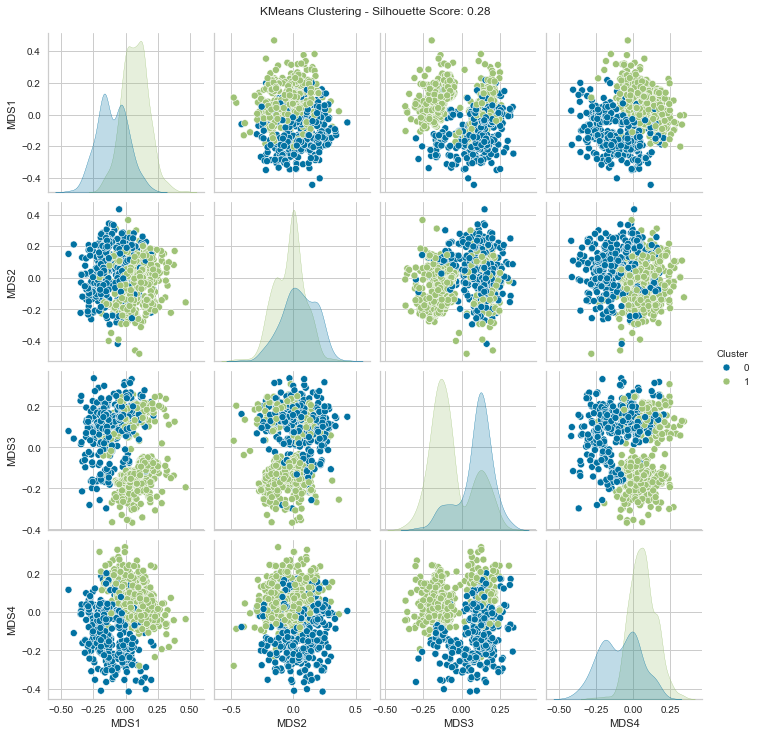

In [44]:
kmeans = MiniBatchKMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X_mds)


# Prepare dataframes for pairplot
df_kmeans = pd.DataFrame(X_mds, columns=['MDS1', 'MDS2', 'MDS3', 'MDS4'])
df_kmeans['Cluster'] = clusters
silhouette = silhouette_score(X_mds, clusters)

# Plot pairplot for training data
sns.pairplot(df_kmeans, hue='Cluster', vars=['MDS1', 'MDS2', 'MDS3', 'MDS4'])
plt.suptitle(f'KMeans Clustering - Silhouette Score: {silhouette:.2f}', y=1.02)
plt.savefig('Dimension_reduction/KMeans.jpg', bbox_inches='tight')
plt.show()

In [51]:
kmeans.cluster_centers_

array([[-0.10462324,  0.04278539,  0.09142099, -0.09299248],
       [ 0.07040465, -0.02864624, -0.06364337,  0.06803875]])

c:\Users\kaami\anaconda3\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


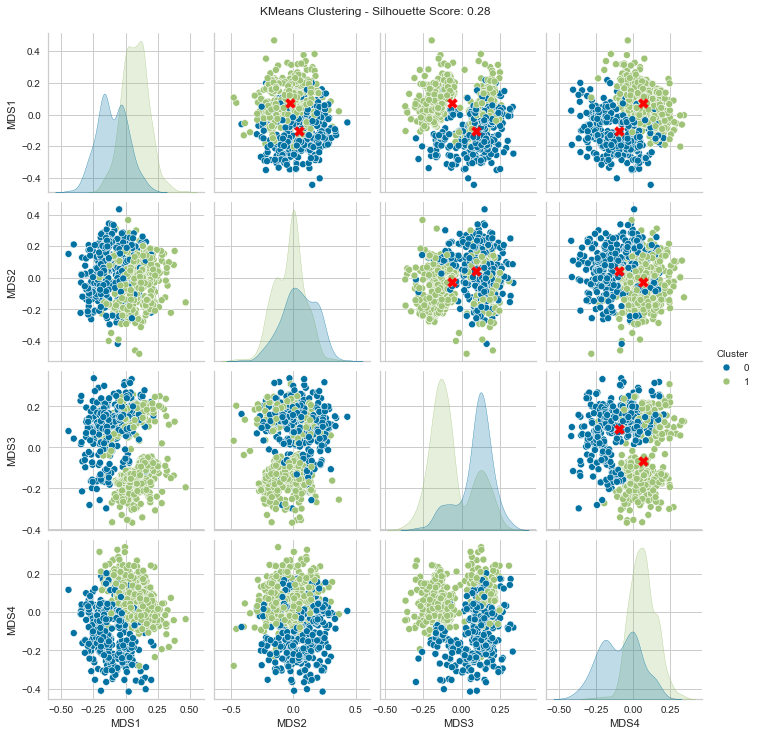

In [57]:
pairplot_train = sns.pairplot(df_kmeans, hue='Cluster', vars=['MDS1', 'MDS2', 'MDS3', 'MDS4'])
for i, j in zip(*np.triu_indices_from(pairplot_train.axes, 1)):
    pairplot_train.axes[i, j].scatter(kmeans.cluster_centers_[:, j], kmeans.cluster_centers_[:, i], 
                                      marker='X', s=100, c='red', label='Centroid')
pairplot_train.fig.suptitle(f'KMeans Clustering - Silhouette Score: {silhouette:.2f}', y=1.02)
# pairplot_train.fig.legend(labels=['Centroid'])
plt.savefig('Dimension_reduction/KMeans.jpg', bbox_inches='tight')
plt.show()

In [38]:
from sklearn.cluster import SpectralClustering
from scipy.spatial.distance import cdist

class ClusterSimilarityMatrix():
    def __init__(self) -> None:
        self._is_fitted = False

    def fit(self, y_clusters):
        if not self._is_fitted:
            self._is_fitted = True
            self.similarity = self.to_binary_matrix(y_clusters)
            return self

        self.similarity += self.to_binary_matrix(y_clusters)

    def to_binary_matrix(self, y_clusters):
        y_reshaped = np.expand_dims(y_clusters, axis=-1)
        return (cdist(y_reshaped, y_reshaped, 'cityblock')==0).astype(int)

class EnsembleSpectralClustering():
    def __init__(self, clusters_number, base_estimator, base_estimator_num_clusters, estimators_num=100, parameters={}):
        self.clusters_number = clusters_number
        self.base_estimator_num_clusters = base_estimator_num_clusters
        self.estimators_num= estimators_num
        self.clustering_models = self.estimators_num*[base_estimator(n_clusters=self.base_estimator_num_clusters, n_init=1, init = 'random', **parameters)]
        
    def fit(self, X):
        clt_sim_matrix = ClusterSimilarityMatrix()
        for model in self.clustering_models:
            clt_sim_matrix.fit(model.fit(X).labels_)
            
        sim_matrix = clt_sim_matrix.similarity
        norm_sim_matrix = sim_matrix/sim_matrix.diagonal()
        
        spec_clt = SpectralClustering(n_clusters=self.clusters_number, affinity='precomputed')
        return spec_clt.fit_predict(norm_sim_matrix)

c:\Users\kaami\anaconda3\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


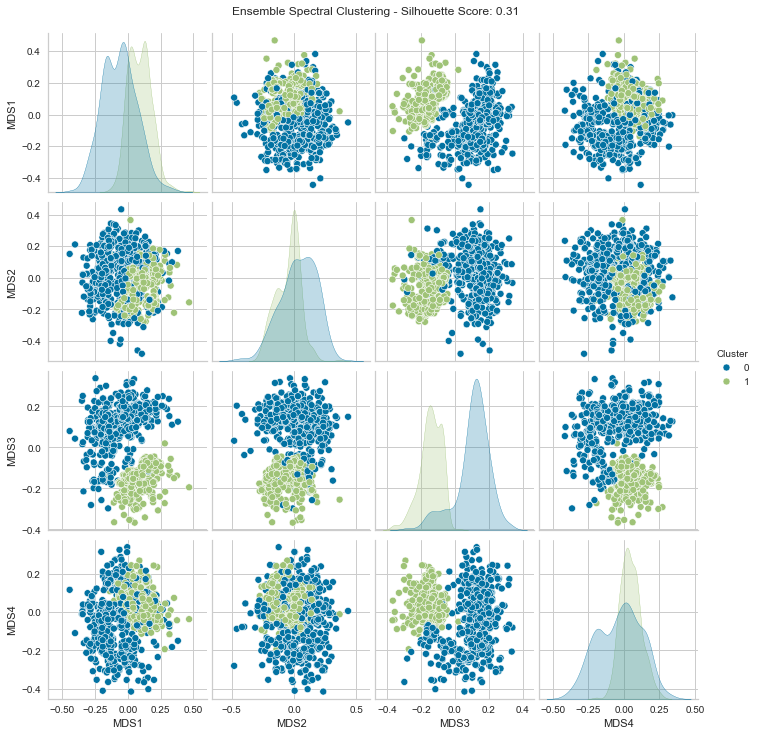

In [43]:
ensemble_cluster = EnsembleSpectralClustering(clusters_number=2,
                                     base_estimator=MiniBatchKMeans,
                                     base_estimator_num_clusters = 20)

clusters = ensemble_cluster.fit(X_mds)

# Prepare dataframes for pairplot
df_kmeans = pd.DataFrame(X_mds, columns=['MDS1', 'MDS2', 'MDS3', 'MDS4'])
df_kmeans['Cluster'] = clusters
silhouette = silhouette_score(X_mds, clusters)

# Plot pairplot for training data
sns.pairplot(df_kmeans, hue='Cluster', vars=['MDS1', 'MDS2', 'MDS3', 'MDS4'])
plt.suptitle(f'Ensemble Spectral Clustering - Silhouette Score: {silhouette:.2f}', y=1.02)
plt.savefig('Dimension_reduction/ensemble.jpg', bbox_inches='tight')
plt.show()

## FAMD

In [46]:
pip install prince

Note: you may need to restart the kernel to use updated packages.


In [183]:
import prince


In [184]:
famd = prince.FAMD(
    n_components=13,
    n_iter=3,
    copy=True,
    check_input=True,
    random_state=42,
    engine="sklearn")  # same parameter as sklearn.preprocessing.OneHotEncoder

f_X = famd.fit(X)

In [185]:
famd.row_coordinates(X)

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.022124,0.566674,-0.721957,-0.589041,0.615901,0.434157,-0.377841,0.903813,-0.649839,-0.202061,-0.008983,0.716068,-0.067116
1,0.213674,0.321847,-1.694674,0.834881,0.085065,-1.594148,-0.416317,0.663899,-0.293767,0.432797,0.569218,-0.108265,-0.167928
2,-0.331998,0.033671,0.101916,0.084591,-0.376405,0.259956,-0.219851,-0.701587,-0.690495,-0.148915,-0.803823,0.371730,0.254193
3,0.372562,0.033989,0.149203,0.755313,-0.644355,-0.757819,0.161559,-0.548751,0.279961,-0.587375,-0.635564,-0.428717,-0.725609
4,-0.745733,0.034434,1.136092,0.748475,-0.031624,0.467704,0.985394,1.476201,1.629458,0.395363,-0.119800,-1.060731,0.363545
...,...,...,...,...,...,...,...,...,...,...,...,...,...
48836,-0.744138,-0.003766,0.578125,-0.216985,0.158733,-0.117299,-0.262681,0.786784,-0.684899,0.286668,-0.260364,-0.342697,0.131939
48837,-0.403924,0.175250,-0.239214,0.457533,0.014766,0.970335,-0.407329,0.700016,-0.544570,0.528083,-0.665032,-0.083791,0.426432
48839,0.483881,-0.193589,1.659885,0.351447,-0.562666,-0.212143,-0.324033,0.875717,-0.051845,0.412350,-0.475112,-0.280886,0.186395
48840,0.467011,1.299546,-0.624290,-0.336361,1.286698,0.376448,0.915426,0.290650,0.269323,-0.043958,0.109861,0.659395,-0.110471


In [174]:
file_path = 'data_preprocessed.csv'
data = pd.read_csv(file_path)
data = data.dropna()


# Identify numerical and categorical columns
numerical_columns = ['age','fnlwgt', 'hours-per-week', 'capital-gain', 'capital-loss']  # Replace with your actual numerical columns
categorical_columns = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']  # Replace with your actual categorical columns
sorted_columns = ['age','fnlwgt', 'hours-per-week', 'capital-gain', 'capital-loss', 'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']

scaler = StandardScaler()
data[numerical_columns] = scaler.fit_transform(data[numerical_columns])

y = pd.get_dummies(data['income'], drop_first=True)
y = y.values.reshape(-1)
X = data.drop('income', axis=1)

#for col in categorical_columns:
 #   X[col] = X[col].astype('category')

#X = X[sorted_columns]

#X, _, y, _ = train_test_split(X, y, train_size=5000, stratify=y, random_state=42)

In [175]:
X.shape

(46033, 13)

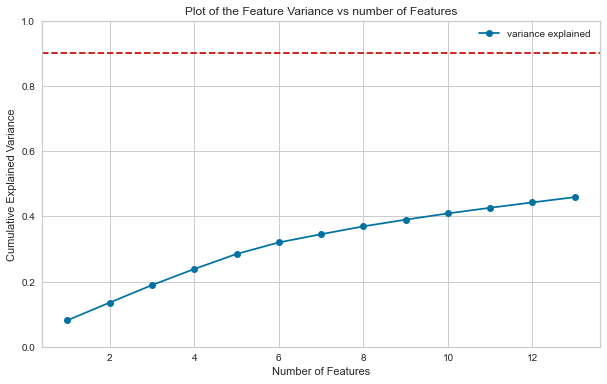

In [176]:
famd = prince.FAMD(
    n_components=13,  # Maksymalna liczba komponentów
    n_iter=3,
    copy=True,
    check_input=True,
    random_state=42,
    engine="sklearn"
)
X_famd = famd.fit(X)

# Wyjaśniona inercja dla każdej składowej
explained_inertia = famd.explained_inertia_

#explained_inertia=famd.cumulative_percentage_of_variance_

# Skumulowana suma wyjaśnionej inercji
cumulative_inertia = np.cumsum(explained_inertia)

# Wykres
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_inertia) + 1), cumulative_inertia, marker='o', linestyle='-', color='b',label='variance explained')
plt.axhline(y=0.9, color='r', linestyle='--')
#plt.text(1, 0.92, '90% cumulative sum', color='g', fontsize=12)

plt.title('Plot of the Feature Variance vs number of Features')
plt.xlabel('Number of Features')
plt.ylim(0,1)
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.legend()
plt.show()

In [177]:
famd.explained_inertia_.sum()

0.45878371485319136

## Dalej nie ma na co patrzeć

In [146]:
X_famd.cumulative_percentage_of_variance_

AttributeError: 'FAMD' object has no attribute 'cumulative_percentage_of_variance_'

In [162]:
famd = prince.FAMD(
    n_components=13,  # Maksymalna liczba komponentów
    n_iter=3,
    copy=True,
    check_input=True,
    random_state=42
)
X_famd = famd.fit(X)

In [163]:
famd.transform(X)

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.022124,0.566674,-0.721957,-0.589041,0.615901,0.434157,-0.377841,0.903813,-0.649839,-0.202061,-0.008983,0.716068,-0.067116
1,0.213674,0.321847,-1.694674,0.834881,0.085065,-1.594148,-0.416317,0.663899,-0.293767,0.432797,0.569218,-0.108265,-0.167928
2,-0.331998,0.033671,0.101916,0.084591,-0.376405,0.259956,-0.219851,-0.701587,-0.690495,-0.148915,-0.803823,0.371730,0.254193
3,0.372562,0.033989,0.149203,0.755313,-0.644355,-0.757819,0.161559,-0.548751,0.279961,-0.587375,-0.635564,-0.428717,-0.725609
4,-0.745733,0.034434,1.136092,0.748475,-0.031624,0.467704,0.985394,1.476201,1.629458,0.395363,-0.119800,-1.060731,0.363545
...,...,...,...,...,...,...,...,...,...,...,...,...,...
48836,-0.744138,-0.003766,0.578125,-0.216985,0.158733,-0.117299,-0.262681,0.786784,-0.684899,0.286668,-0.260364,-0.342697,0.131939
48837,-0.403924,0.175250,-0.239214,0.457533,0.014766,0.970335,-0.407329,0.700016,-0.544570,0.528083,-0.665032,-0.083791,0.426432
48839,0.483881,-0.193589,1.659885,0.351447,-0.562666,-0.212143,-0.324033,0.875717,-0.051845,0.412350,-0.475112,-0.280886,0.186395
48840,0.467011,1.299546,-0.624290,-0.336361,1.286698,0.376448,0.915426,0.290650,0.269323,-0.043958,0.109861,0.659395,-0.110471


In [164]:
X_famd.cumulative_percentage_of_variance_()

AttributeError: 'FAMD' object has no attribute 'cumulative_percentage_of_variance_'

In [166]:
famd = prince.FAMD(n_components=26) 
X_famd = famd.fit(X)

In [167]:
X_famd.cumulative_percentage_of_variance_

AttributeError: 'FAMD' object has no attribute 'cumulative_percentage_of_variance_'

In [179]:
import prince

In [181]:
ff = prince.FAMD(n_components=13) 
ff = ff.fit(X)

In [182]:
ff.cumulative_percentage_of_variance_.s

AttributeError: 'FAMD' object has no attribute 'cumulative_percentage_of_variance_'

In [ ]:
%